# Lockdown optimisation on an SIR model using JuMP.jl 

Initial version [here](https://github.com/epirecipes/sir-julia/blob/master/markdown/function_map_lockdown_jump/function_map_lockdown_jump.md) by Simon Frost (@sdwfrost)\
Current version Sandra Montes (@slmontes), 2025-03-10

## Introduction

This example explores the optimal control of an SIR (Susceptible-Infected-Recovered) model using a time-varying intervention that reduces the infection rate. The population is divided into three categories: susceptible individuals (`S`), infected individuals (`I`), and the total number of cases (`C`). The intervention is modelled as a time-dependent control variable `υ(t)` that reduces the transmission rate by a factor of `1 - υ(t)`. The goal is to determine the optimal timing and application of this intervention to minimise the final number of cases (`C`) under the following constraints: (a) `υ` cannot exceed a maximum value, and (b) the total cost, measured as the integral of `υ` over time, must remain within a specified limit.

The model is described by the following differential equations:

$$
\begin{aligned}
\dfrac{\mathrm{d}S}{\mathrm{dt}} &= -\beta (1 - \upsilon(t)) S I, \\
\dfrac{\mathrm{d}I}{\mathrm{dt}} &= \beta (1 - \upsilon(t)) S I - \gamma I, \\
\dfrac{\mathrm{d}C}{\mathrm{dt}} &= \beta (1 - \upsilon(t)) S I,
\end{aligned}
$$

Here, `β` is the transmission rate, and `γ` is the recovery rate. 

In a study by [Britton and Leskela (2022)](https://epubs.siam.org/doi/10.1137/22M1504433), it was demonstrated that the optimal strategy for controlling the epidemic under the above model involves a single lockdown at a set maximum intervention level for `υ`, sustained until the cost reaches the specified threshold. To determine whether the optimal policy can be identified numerically, we use a simple Euler discretisation and then use JuMP.jl with IPOPT to optimise.


## Libraries

In [1]:
using OrdinaryDiffEq
using DiffEqCallbacks
using JuMP
using Ipopt
using Plots
using DataInterpolations
using NonlinearSolve;

## Functions

ODE system

In [2]:
function sir_ode!(du,u,p,t)
    (S, I, C) = u
    (β, γ, υ) = p
    @inbounds begin
        du[1] = -β*(1-υ)*S*I
        du[2] = β*(1-υ)*S*I - γ*I
        du[3] = β*(1-υ)*S*I
    end
    nothing
end;

SIR simulation

In [3]:
function simulate(p, u0, t₁, dur, ss, alg)
    t₂ = t₁ + dur
    lockdown_times = [t₁, t₂]
    β, γ, υ = p
    function affect!(integrator)
        if integrator.t < lockdown_times[2]
            integrator.p[3] = υ
        else
            integrator.p[3] = 0.0
        end
    end
    cb = PresetTimeCallback(lockdown_times, affect!)
    tspan = (0.0, t₂+ss)
    # Start with υ=0   
    prob = ODEProblem(sir_ode!, u0, tspan, [β, γ, 0.0])
    sol = solve(prob, alg, callback = cb)
    return sol
end;

Calculate the total number of infected at the end of simulation

In [4]:
function final_size(p, u0, t₁, dur, ss, alg)
    sol = simulate(p, u0, t₁, dur, ss, alg)
    return sol[end][3]
end;

## Running the model without intervention

Parameters

In [5]:
u0 = [0.99, 0.01, 0.0]; #S, I, C (cumulative incidence)
p = [0.5, 0.25, 0]; # β, γ, υ

In [6]:
t0 = 0.0
tf = 100
dt = 0.1
ts = collect(t0:dt:tf)
alg = Tsit5();

Solve using ODEProblem

In [7]:
prob1 = ODEProblem(sir_ode!, u0, (t0, tf), p)
sol1 = solve(prob1, alg, saveat=ts);

Without control the final size of total number of cases is $\sim$ 79%

In [8]:
fianl_C_sol1 = sol1[end][3]
println("Cumulative incidence fraction without control: ", fianl_C_sol1)

Cumulative incidence fraction without control: 0.7901973301765105


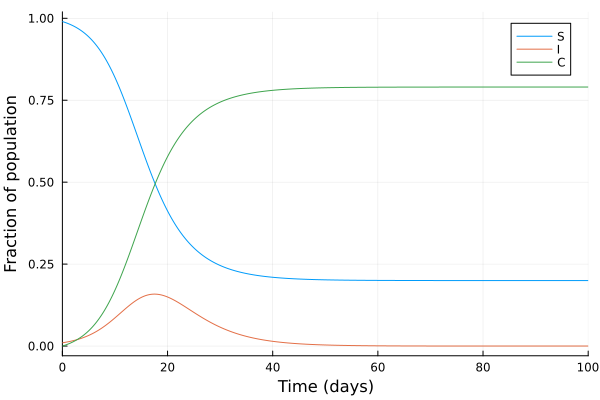

In [9]:
plot(sol1,
     xlim=(0, 100),
     labels=["S" "I" "C"],
     xlabel="Time (days)",
     ylabel="Fraction of population")

Now we find the peak value of infected individuals and the time at which it occurs:

In [10]:
peak_value, peak_index = findmax(sol1[2, :]) 
peak_time = sol1.t[peak_index]
println("The peak of infections occurs at time: ", peak_time)

The peak of infections occurs at time: 17.5


## Running the model with intervention initiated at the peak of infected cases

Demonstrating the impact of an intervention when initiated at the peak of infected cases.\
Parameters:

In [11]:
p2 = copy(p)
p2[3] = 0.5;   #Set υ to 0.5
t₁ = peak_time
dur = 20.0  #Duration of the intervention
ss = 100.0;

Simulate with intervention

In [12]:
sol2 = simulate(p2, u0, t₁, dur, ss, alg);

With control starting at the peak of infections and lasting 20 days, the final size of total number of cases is $\sim$ 63%

In [13]:
fianl_C_sol2 = sol2[end][3]
println("Cumulative incidence fraction when control starts at the peak: ", fianl_C_sol2)

Cumulative incidence fraction when control starts at the peak: 0.6312297734667601


In [14]:
# create a vector that shows the υ value for each time step
υ_test = zeros(length(ts))
for i in 1:length(ts)
    if ts[i] >= t₁ && ts[i] <= (t₁ + dur)
        υ_test[i] = 0.5  # Set to 0.5 within the time interval
    end
end

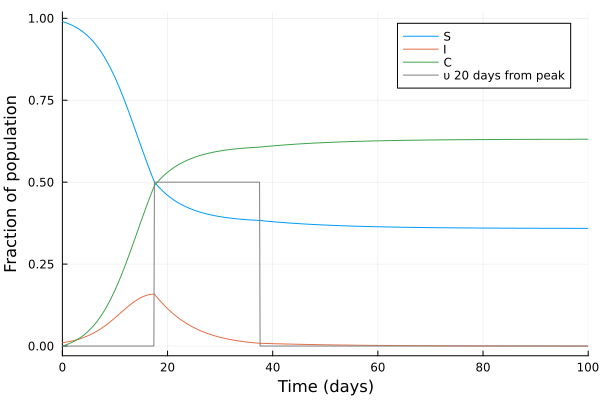

In [15]:
plot(sol2,
     xlim=(0, 100),
     labels=["S" "I" "C"],
     xlabel="Time (days)",
     ylabel="Fraction of population")
plot!(ts, υ_test, color=:gray, label="υ 20 days from peak")

## Searching for the optimal intervention time

Parameters

In [16]:
β = p2[1]
γ = p2[2]
υ_max = p2[3]
υ_total = 10.0; # maximum cost

S0 = u0[1]
I0 = u0[2]
C0 = u0[3]

T = Int(tf/dt)

silent = true;

Model setup

In [17]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "max_iter", 1000)
if !silent
    set_optimizer_attribute(model, "output_file", "JuMP_lockdown.txt")
    set_optimizer_attribute(model, "print_timing_statistics", "yes")
end;

Variables:

In [18]:
@variable(model, 0 <= S[1:(T+1)] <= 1)
@variable(model, 0 <= I[1:(T+1)] <= 1)
@variable(model, 0 <= C[1:(T+1)] <= 1)
@variable(model, 0 <= υ[1:(T+1)] <= υ_max);

We can discretise the SIR model in different ways, but here we use a simple Euler discretisation:

In [19]:
@expressions(model, begin
        infection[t in 1:T], (1 - υ[t]) * β * I[t] * dt * S[t]  # Linear approximation of infection rate
        recovery[t in 1:T], γ * dt * I[t] # Recoveries at each time step
    end);

In [20]:
@constraints(model, begin
    S[1]==S0
    I[1]==I0
    C[1]==C0
    [t=1:T], S[t+1] == S[t] - infection[t]
    [t=1:T], I[t+1] == I[t] + infection[t] - recovery[t]
    [t=1:T], C[t+1] == C[t] + infection[t]
    dt * sum(υ[t] for t in 1:T+1) <= υ_total
end);

In [21]:
@objective(model, Min, C[T+1]);

In [22]:
if silent
    set_silent(model)
end
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [23]:
termination_status(model)

LOCALLY_SOLVED::TerminationStatusCode = 4

In [24]:
S_opt = value.(S)
I_opt = value.(I)
C_opt = value.(C)
υ_opt = value.(υ);

Plotting the results shows that the optimiser has identified a policy similar to the one suggested by [Britton and Leskela (2022)](https://arxiv.org/abs/2202.07780), which is a single lockdown of intensity `υ_max` and a duration `υ_total/υ_max`. But the optimiser has also identified a time to start the lockdown that is not the peak of the infection curve.

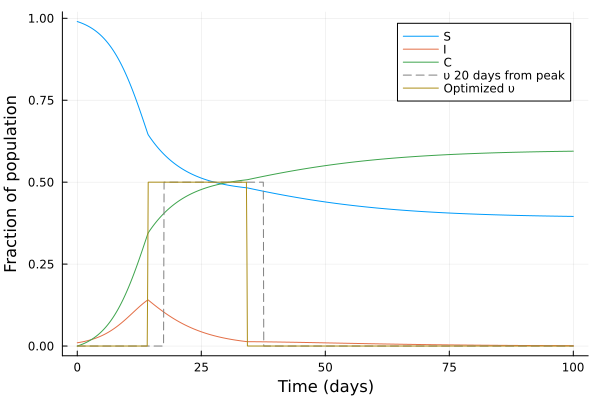

In [25]:
plot(ts, S_opt, label="S", xlabel="Time (days)", ylabel="Fraction of population")
plot!(ts, I_opt, label="I")
plot!(ts, C_opt, label="C")
plot!(ts, υ_test, color=:gray, linestyle=:dash, label="υ 20 days from peak")
plot!(ts, υ_opt, label="Optimized υ")

In [26]:
tolerance = 1e-3
max_indices = findall(x -> abs(x - υ_max) < tolerance, υ_opt)
max_times = ts[max_indices]
intervention_length = length(max_indices)*dt

println("Duration of intervention in days: ", intervention_length)
println("The start of intervention is at time: ",  max_times[1])

Duration of intervention in days: 19.900000000000002
The start of intervention is at time: 14.3


With control starting at the optimased time and lasting $\sim$ 20 days, the final size of total number of cases is $\sim$ 59%

In [27]:
fianl_C_sol3 = C_opt[end]
println("Cumulative incidence fraction when control is optimised: ", fianl_C_sol3)

Cumulative incidence fraction when control is optimised: 0.5945130623911311


Now we use the `final sizes` function to produce simulations at different start times. In the following plot we can observe how the a 20-day constant-level lockdown of 0.5 the lowest Cumulative incidence is obtained at the optimal time found prevoiusly.

In [ ]:
t_opt = max_times[1]
fs(u, p_) = final_size(p2, u0, u[1], dur, ss, alg);
final_sizes = [fs([x], []) for x in ts]
plot(ts,
     final_sizes,
     xlabel="Time of intervention",
     ylabel="Cumulative incidence",
     ylim=(0,1),
     xlim=(0,40),
     legend=false,
     linewidth=3, xtickfontsize=14, ytickfontsize=14, xguidefontsize=16, yguidefontsize=16)
vline!([t_opt],linewidth=3)
# savefig("trad_plot.png")

"/Users/sandramo/Repos/EpiPolicies/NPIs/Lockdown/trad_plot.png"

We can also calculate the effective reproductive number, `Rₜ′` in the presence of the intervention 

In [29]:
Rₜ_opt = β.* S_opt ./γ   #Not taking into account the intervention
Rₜ′_opt = Rₜ_opt .* (1 .- υ_opt);  #Taking into account the intervention

And calculate the time at which `Rₜ==1` using a root-finding approach:

In [30]:
Rₜ_interp = CubicSpline(Rₜ_opt,ts)
f(u, p) = [Rₜ_interp(u[1]) - 1.0]
u0 = [(tf-t0)/3]
Rtprob = NonlinearProblem(f, u0)
Rtsol = solve(Rtprob, NewtonRaphson(), abstol = 1e-9).u[1];

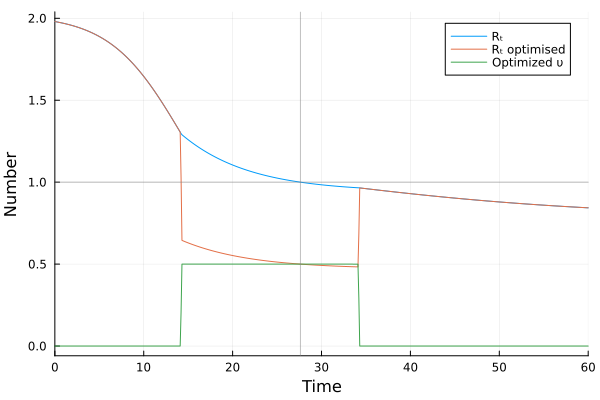

In [31]:
plot(ts, Rₜ_opt, label="Rₜ", xlabel="Time", ylabel="Number", legend=:topright, xlim=(0,60))
plot!(ts, Rₜ′_opt, label="Rₜ optimised")
plot!(ts, υ_opt, label="Optimized υ")
vline!([Rtsol], color=:gray, alpha=0.5, label=false)
hline!([1.0], color=:gray, alpha=0.5, label=false)

## Discussion

We mentioned that different discretisation methods can be used. We also tried discretising the system using exponential approximations to model the transition probabilities. If we model the time between transitions (such as infections or recoveries) as an exponentially distributed random variable with rate `λ`, the probability of transition between states during the interval `dt` can be approximated by:

$$
\begin{aligned}
1−exp(−λ⋅dt),
\end{aligned}
$$

For larger `dt`, this method may be more accurate than a simple Euler approximation. However, smaller timesteps, although giving results closer to the continuous time system, resulted in the solver struggling to converge. Therefore, at the chosen `dt==0.1`, the simple Euler discretisation provided better results. 

We could also have used other optimisation methods by fixing the intervention length to 20 days and optimising the start of the intervention, which can be observed when we compared the optimal time obtained with the lowest cumulative incidence found simulating different intervention start times using the function `final size`. However, JuMP optimisation's advantage is that we could numerically  confirm that according to the constraints set to the intervention cost and total cases, the optimal intervention was a single lockdown at the maximum level set and for a period of $\sim$ 20 simulated days.